In [90]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import plio
import numpy as np
from autocnet.cg import cg as util
from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.matcher.feature import FlannMatcher
from scipy.spatial import Voronoi, voronoi_plot_2d
import pandas
from IPython.display import display

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [91]:
def voronoi(edge, node, clean_keys=[]):
    #node = {'destination':destination, 'source':source}
    if node == "destination":
        matches, mask = edge.clean(clean_keys=clean_keys)
        indices = pandas.Index(matches['destination_idx'].values)
        
        keypointsPd = edge.destination.get_keypoint_coordinates(index=indices)
        convex_coords = edge.source.geodata.xy_corners
    else:
        matches, mask = edge.clean(clean_keys=clean_keys)
        indices = pandas.Index(matches['source_idx'].values)

        keypointsPd = edge.source.get_keypoint_coordinates(index=indices)
        convex_coords = edge.destination.geodata.xy_corners

    keypoints = np.array(keypointsPd)
    print(keypointsPd)
    edges = np.array([[-50, -50], [-50, 1062], [1063, 1063], [1063, -50]])
    print(edges)
    keypoints = numpy.append(keypoints, edges, axis=0)
    print(keypoints)
    vor = Voronoi(keypoints, incremental = False) 
    
    polygon_array = []
    for region in vor.regions:
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            poly_points = np.array(polygon)
            #poly_hull = util.convex_hull(poly_points)
            convex_hull = util.convex_hull(convex_coords)
            #overlap = polygon.Intersection(convex_hull)
            polygon_array += polygon
    return vor

              x           y
214  657.087646   15.598222
320   92.411133  285.567230
74   262.194427  652.447510
125  669.161621  653.286194
365  293.368866  755.385742
471  720.421631  769.308655
286  686.811218  812.389221
314  135.337616  588.148804
34   762.355164  997.376099
227  253.830536  973.832825
229   43.467659  961.529358
35   693.823486  971.273682
132  457.213226  867.798767
65   416.421600  788.903564
297  663.345154  838.311707
301  246.971024  785.753784
414  757.916809  883.206360
289  724.273193  819.445923
291  702.968018  816.803345
262  418.104858  764.581055
44   502.160187  925.671021
47   502.160187  925.671021
86   312.453857  913.640625
254  567.092651  744.184204
424  327.631561  961.232117
425  327.631561  961.232117
317  275.844604  855.409485
311  679.158142  791.807678
172  602.012268  478.217987
31   639.119019  998.439270
..          ...         ...
25    32.522339   51.783314
112  703.580872  276.749146
184  221.989166  547.352234
216   33.673618  743

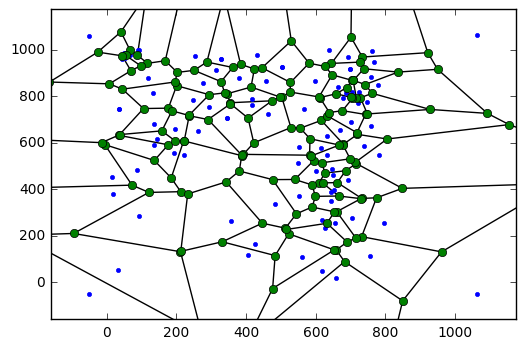

In [92]:
#Point to the adjacency Graph
adjacency = get_path('three_image_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(method='sift', extractor_parameters={'nfeatures':500})

#Match
cg.match_features()

#Apply outlier detection
cg.apply_func_to_edges(Edge.symmetry_check)
cg.apply_func_to_edges(Edge.ratio_check)
m = cg.edge[0][1].masks
cg.minimum_spanning_tree()

#Compute a homography and apply RANSAC
cg.apply_func_to_edges("compute_fundamental_matrix", clean_keys=['ratio', 'symmetry'])
extent = cg.edge[0][1].source.geodata.xy_extent

vor = voronoi(cg.edge[0][1], 'source', clean_keys = ['fundamental'])

#print(dir(vor))

voronoi_plot_2d(vor)
plt.show()

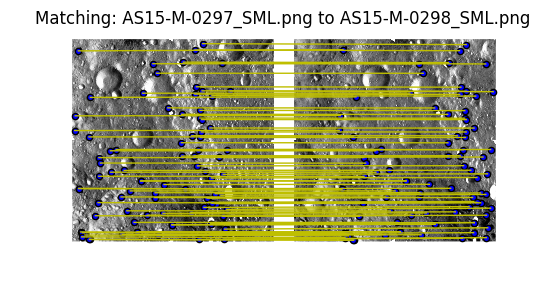

In [93]:
fig, ax = plt.subplots(1,1)
ax = cg.edge[0][1].plot(clean_keys=['ratio', 'symmetry', 'fundamental'], ax=ax)

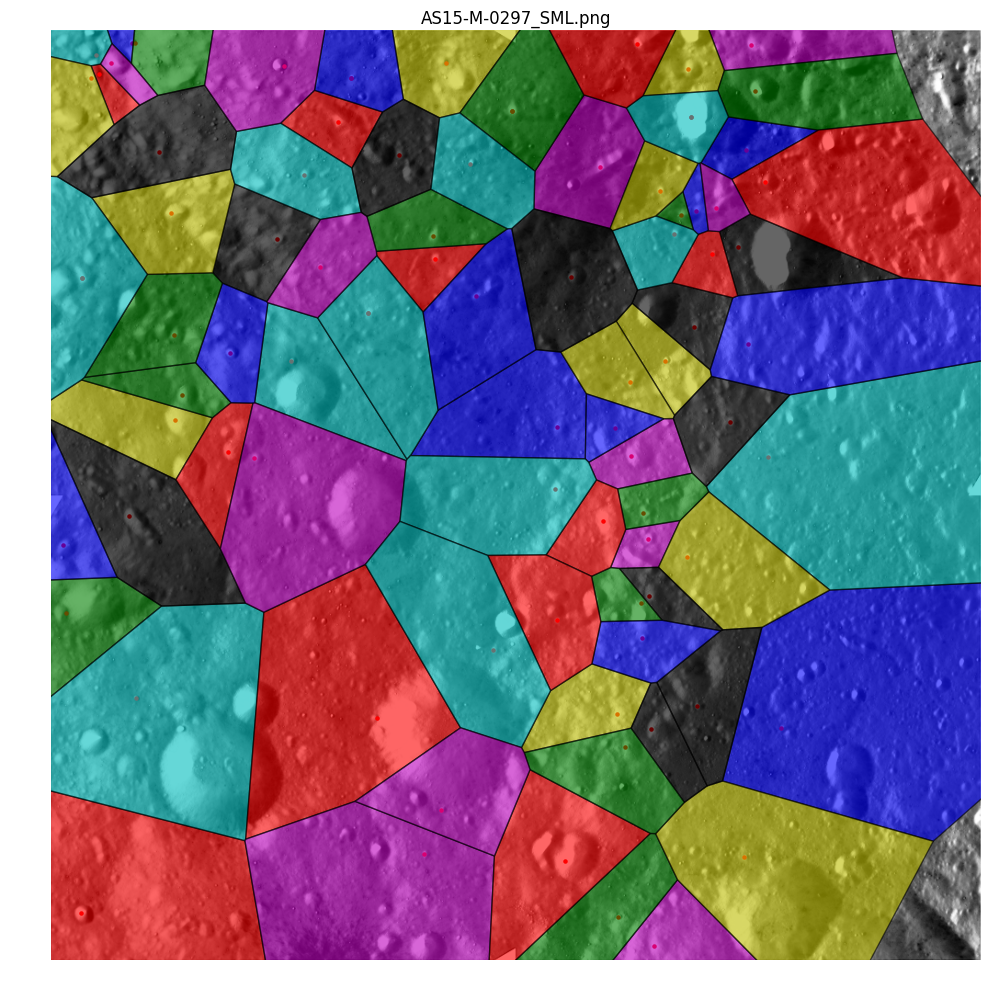

In [105]:
figure(num=None, figsize=(12, 12))
for region in vor.regions:
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), alpha = .6)

plt.xlim(vor.min_bound[0] + 50, vor.max_bound[0] - 50)
plt.ylim(vor.min_bound[1] + 50, vor.max_bound[1] - 50)
# 

matches, mask = cg.edge[0][1].clean(clean_keys=['fundamental'])
indices = pandas.Index(matches['source_idx'].values)
        
cg.edge[0][1].source.plot(index_mask=indices)
plt.show()

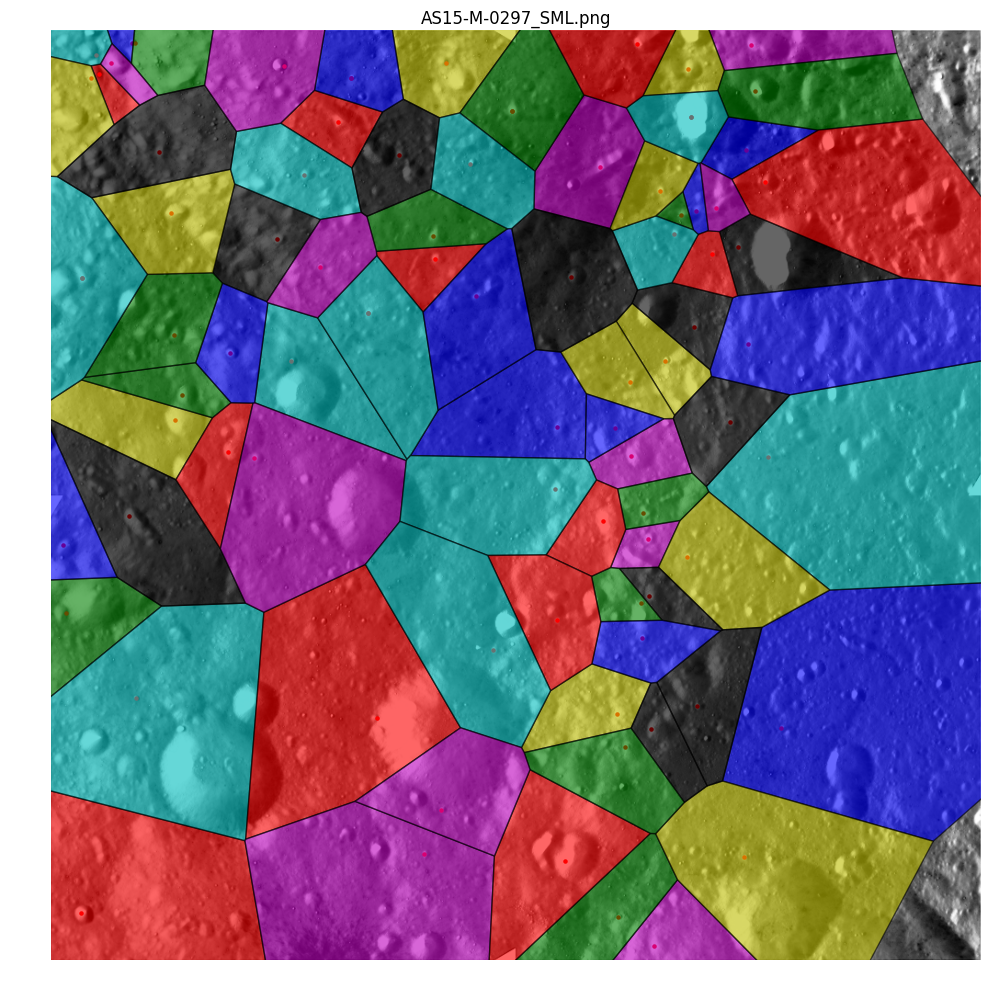

In [106]:
figure(num=None, figsize=(12, 12))
for region in vor.regions:
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), alpha = .6)

plt.xlim(vor.min_bound[0] + 50, vor.max_bound[0] - 50)
plt.ylim(vor.min_bound[1] + 50, vor.max_bound[1] - 50)
# 

matches, mask = cg.edge[0][1].clean(clean_keys=['fundamental'])
indices = pandas.Index(matches['source_idx'].values)
        
cg.edge[0][1].source.plot(index_mask=indices)
plt.show()

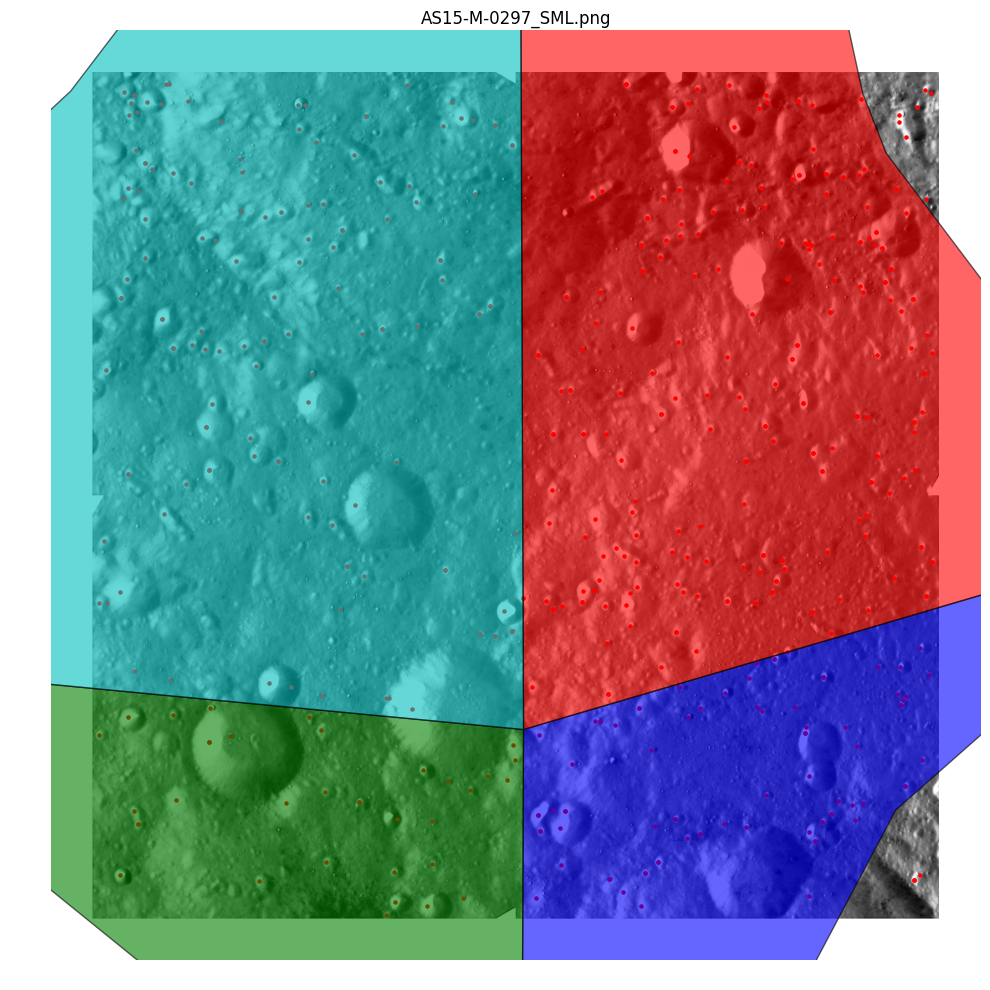

In [103]:
figure(num=None, figsize=(12, 12))
for region in vor.regions:
    if -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), alpha = .6)

plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

cg.edge[0][1].source.plot()
plt.show()